1️⃣ 전체 플로우

1. 텍스트 추출 (OCR)
- **PaddleOCR** 사용 → 설계도에서 모든 텍스트 + 좌표 추출

2. 도형/선 탐지 (VLM)
- Florence-2 Caption to Phrase Grounding → 도형/선 영역 + 라벨 추출

3. 텍스트-도형 매핑
- OCR 좌표와 도형 좌표 비교 → 도형 안에 포함되는 텍스트 연결

4. 후처리
- 코드/한글 분리, 누락 글자 보정

5. 최종 JSON
- {"type": "block", "coords": [...], "text": "..."} 형식


In [1]:
import cv2
from paddleocr import PaddleOCR
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
import json

# -------------------------------
# 0. 이미지 로드
# -------------------------------
image_path = "./data/test01.JPG"

# -------------------------------
# 1. OCR
# -------------------------------
ocr_test = PaddleOCR(use_angle_cls=True, lang='korean')  
result = ocr_test.ocr(image_path)

# result[0]['rec_texts']      # 인식된 텍스트 리스트
# result[0]['rec_scores']     # 각 텍스트 신뢰도
# result[0]['rec_polys']      # 각 텍스트 영역 좌표
# result[0]['textline_orientation_angles']  # 라인 회전 정보

# TODO

# -------------------------------
# 2. VLM
# -------------------------------
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
torch_dtype = torch.float32
# print("------------------ Setup Check ------------------")
# print("Using device:", device)
# print("Using torch_dtype:", torch_dtype)

model_id = "microsoft/Florence-2-large"
print("Loading Florence-2 Large model...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch_dtype             # torch.float32
).eval().to(device)

processor = AutoProcessor.from_pretrained(model_id,trust_remote_code=True)

###
image = Image.open(image_path).convert("RGB")

def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))

    print(parsed_answer)
    return parsed_answer
    
prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
vlm_result = run_example(prompt, text_input="Extract blocks and lines from the schematic.")
shapes = vlm_result['<CAPTION_TO_PHRASE_GROUNDING>']
blocks = shapes['bboxes']
labels = shapes['labels']

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_638777/2450435274.py:16: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr_test = PaddleOCR(use_angle_cls=True, lang='korean')
/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete th

Loading Florence-2 Large model...
{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[27.50550079345703, 37.29600143432617, 1637.8275146484375, 1146.7039794921875], [27.50550079345703, 38.47999954223633, 1637.8275146484375, 1146.7039794921875]], 'labels': ['Extract blocks', 'lines']}}


In [2]:
# -------------------------------
# TODO: OCR 텍스트와 도형 매핑
# -------------------------------

# OCR 결과 정리
ocr_texts = []
for line in result[0]['rec_texts']:
    # result[0]['rec_polys']와 함께 사용
    # rec_polys: 각 텍스트 영역 좌표 [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
    idx = result[0]['rec_texts'].index(line)
    quad = result[0]['rec_polys'][idx]
    ocr_texts.append({"quad": quad, "text": line})

# 도형과 OCR 텍스트 매핑
mapped_results = []

for bbox, label in zip(blocks, labels):
    x1, y1, x2, y2 = bbox
    contained_texts = []
    
    for ocr_item in ocr_texts:
        # OCR 텍스트 영역 좌표
        ox = [p[0] for p in ocr_item['quad']]
        oy = [p[1] for p in ocr_item['quad']]
        
        # 단순 포함 여부 체크
        if min(ox) >= x1 and max(ox) <= x2 and min(oy) >= y1 and max(oy) <= y2:
            contained_texts.append(ocr_item['text'])
    
    mapped_results.append({
        "type": label,
        "coords": [x1, y1, x2, y2],
        "text": " ".join(contained_texts)
    })



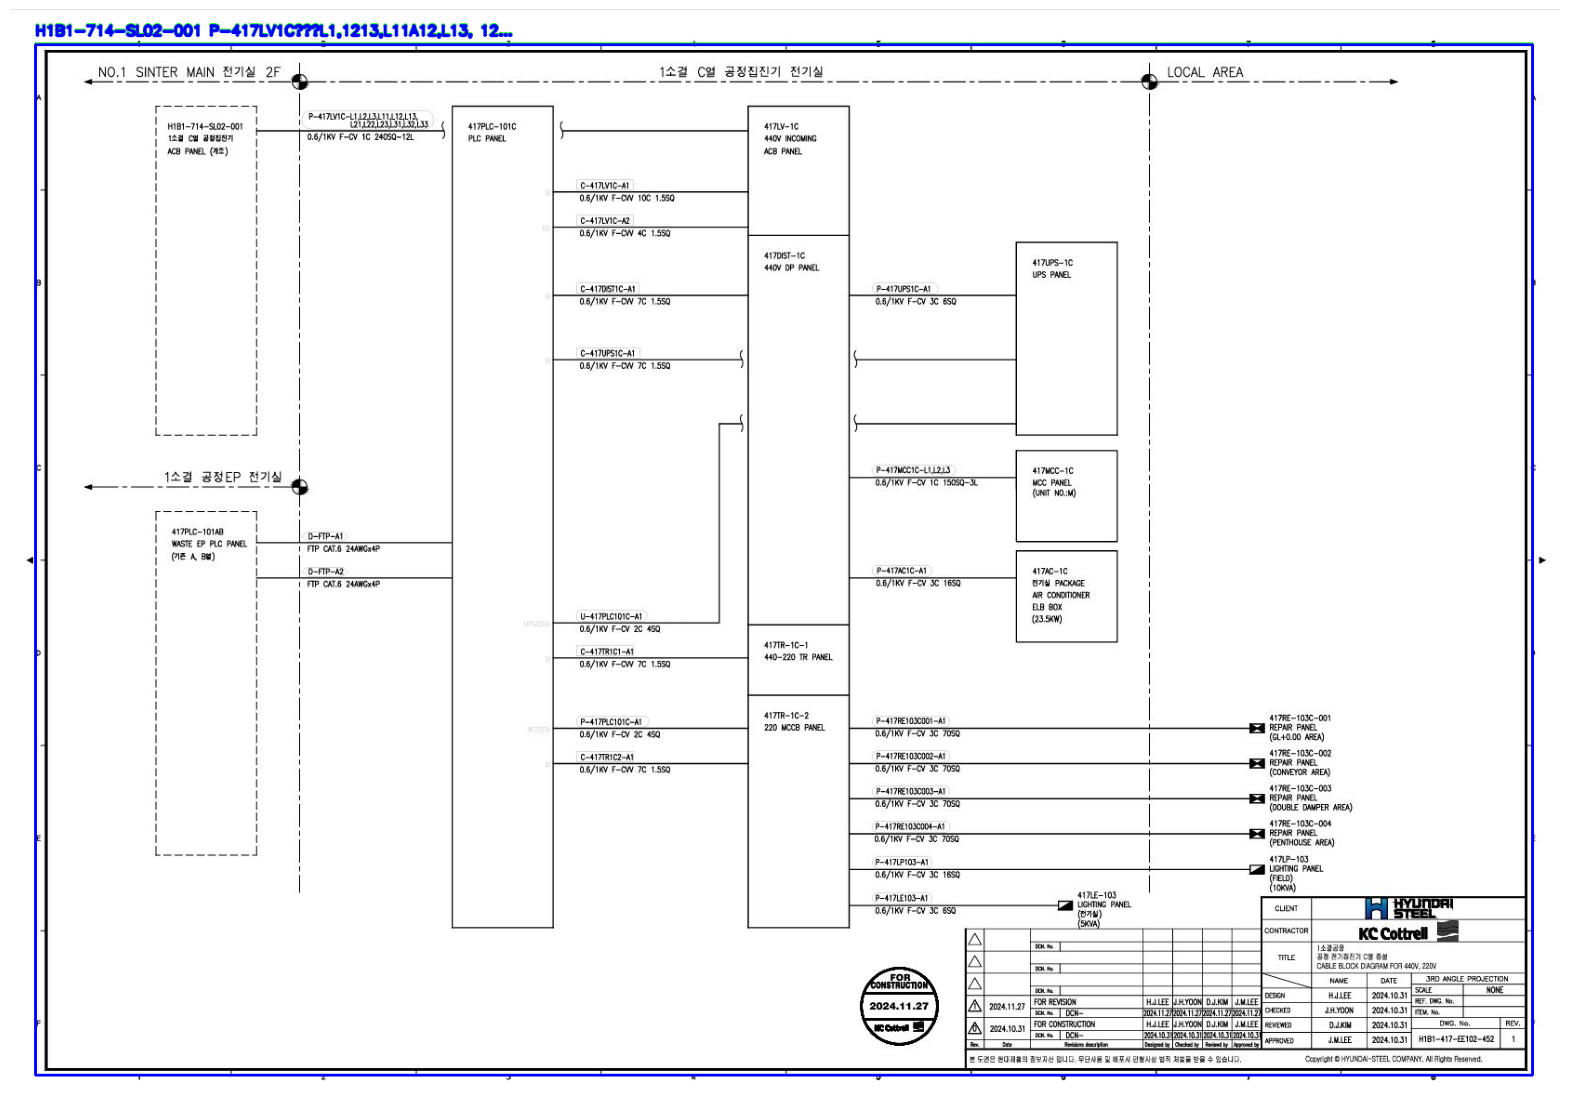

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# OpenCV로 이미지 로드
img_cv = cv2.imread(image_path)

for item in mapped_results:
    x1, y1, x2, y2 = map(int, item['coords'])
    label = item['type']
    text = item['text']

    # 도형 박스 색상
    color = (0, 255, 0) if label.lower() == 'extract blocks' else (255, 0, 0)
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)

    # 텍스트 일부 표시 (길면 자르기)
    display_text = text[:50] + "..." if len(text) > 50 else text
    cv2.putText(img_cv, display_text, (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

# BGR → RGB 변환
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [4]:
mapped_results

[{'type': 'Extract blocks',
  'coords': [27.50550079345703,
   37.29600143432617,
   1637.8275146484375,
   1146.7039794921875],
  'text': 'H1B1-714-SL02-001 P-417LV1C–L1,1213,L11A12,L13, 121,122123,31132,L33 417PLC-101C 417V-1C 1소결CI공정집진기 0.6/1KV F-CV 1C 240SQ-12L PLC PANEL 440V INCOMING ACB PANEL (제조) ACB PANEL C-417LVIC-A1  0.6/1KV F-CW 10C 1.5SQ C-417LVIC-A2 10 0.6/1KV F-CW 4C 1.5SQ 417DIST-1C 440V DP PANEL 417UPS-1C UPS  PANEL C-417DSTIC-A1 P-417UPS1C-A1 I 0.6/1KV F–CW 7C 1.5SQ 0.6/1KV F-CV 3C 6S0 C-417UPS1C-A1  0.6/1KV F–CW 7C 1.5S0 1소결 공정EP 전기실 P-417MCC1C-L1.12,L3 417MCC-1C 0.6/1KV F-CV 1C 150SQ-3L MCCPANEL (UNT NO.M) 417PLC-101A8 WASTE EP PLC PANEL D-FTP-A1 (기존 A B) 1  FTP CAT.6 24AWGx4P D-FTP-A2 P-417AC1C-A1 417AC-1C FTP  CAT.6  24AWGx4P 0.6/1KV F-CV 3C 16SQ 전기실 PACKAGE AR CONDITONER U-417PLC101C-A1 ELB BOX 0.6/1KV F-CV 2C 4S0 (23.5KW) C-417TR1C1-A1 417TR-1C-1 I 0.6/1KV F–CW 7C 1.5SQ 440-220 TR PANEL P-417PLC101C-A1 417TR-1C-2 P-417RE1030001-A1 REPAR PANEL 417RE-103C-001 0.6/1

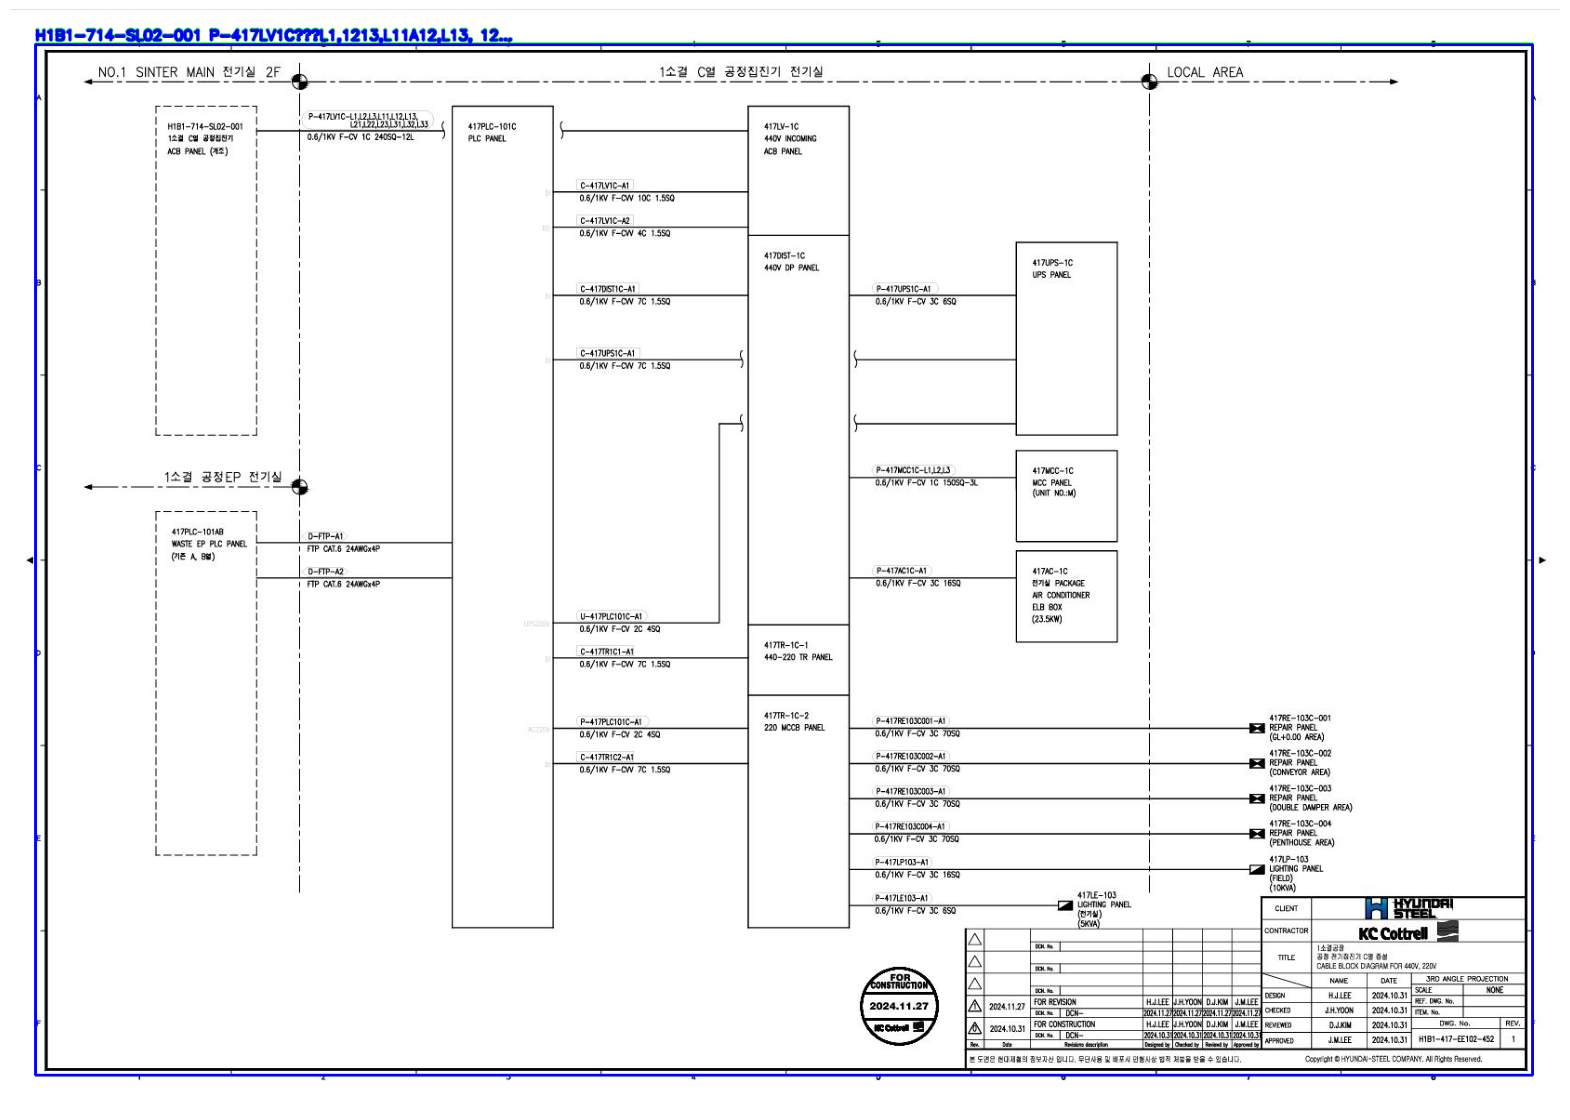

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# OpenCV로 이미지 로드
img_cv = cv2.imread(image_path)

for item in mapped_results:
    label = item['type']
    text = item['text']

    # 색상 설정
    color = (0, 255, 0) if label.lower() == 'extract blocks' else (255, 0, 0)

    # -----------------------
    # 1️⃣ 도형 박스 그리기 (quad)
    # -----------------------
    # item 안에 quad 좌표가 있으면 그대로 사용
    if 'quad' in item:
        quad_pts = np.array(item['quad'], np.int32)
        quad_pts = quad_pts.reshape((-1, 1, 2))
        cv2.polylines(img_cv, [quad_pts], isClosed=True, color=color, thickness=2)
    else:
        # 기존 bbox fallback
        x1, y1, x2, y2 = map(int, item['coords'])
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)

    # -----------------------
    # 2️⃣ 텍스트 표시
    # -----------------------
    if 'quad' in item:
        # quad 좌표 기준 텍스트 위치: 좌상단 점 사용
        x_text, y_text = map(int, item['quad'][0])
    else:
        x_text, y_text = map(int, item['coords'][:2])

    # 글자가 너무 길면 50자만 표시
    display_text = text[:50] + "..." if len(text) > 50 else text
    cv2.putText(img_cv, display_text, (x_text, y_text - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

# -----------------------
# 3️⃣ 이미지 표시 (Jupyter/Notebook 안전)
# -----------------------
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()
